<a href="https://colab.research.google.com/github/piyush-an/INFO7374_Predict_StockPrice/blob/main/4_Model_Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Part - 4: Proposed and train 3-6 models
 - Compare the model performance using RMSE between the fitted Y and actual Y in testing period

## Importing libraries

In [ ]:
%%bash

pip install pandas yfinance ta seaborn matplotlib pandas-datareader jinja2 fredapi openpyxl xgboost scikit-learn statsmodels mlflow


In [2]:
import pandas as pd
from datetime import datetime
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import math
import xgboost as xgb
from sklearn.linear_model import Lasso
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope

pd.set_option("display.max_columns", None)
plt.rcParams["figure.figsize"] = (15, 20)

## MLFlow Experiment Tracking

In [3]:
import mlflow
from mlflow.entities import ViewType
from mlflow.tracking import MlflowClient

MLFLOW_TRACKING_URI = "http://mlflow.anandpiyush.com"
SET_EXPERIMENT = "INFO7374_team_nvdia"
EXPERIMENT_ID = "5"

mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)
mlflow.set_experiment(SET_EXPERIMENT)
client = MlflowClient(tracking_uri=MLFLOW_TRACKING_URI)
mlflow.sklearn.autolog(silent=True)
mlflow.xgboost.autolog(silent=True)
mlflow.statsmodels.autolog()

## NVIDIA Latest Prices

In [4]:
start_date = datetime(2023, 7, 1)
end_date = datetime(2023, 12, 31)

NVDA_STOCK = yf.download("NVDA", start_date, end_date)
NVDA_STOCK.head()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-07-03,425.170013,428.980011,422.019989,424.130005,424.057770,19820900
2023-07-05,421.350006,431.769989,420.850006,423.170013,423.097961,32361800
2023-07-06,418.440002,421.790009,413.459991,421.029999,420.958313,30358200
2023-07-07,423.220001,432.140015,421.799988,425.029999,424.957642,35525300
2023-07-10,426.570007,428.109985,416.489990,421.799988,421.728180,35390800


## Train & Test Data Split

In [5]:
nvda = pd.read_csv("https://raw.githubusercontent.com/piyush-an/INFO7374_Predict_StockPrice/main/NVDA_feature_mart.csv")
nvda.set_index("Unnamed: 0", inplace=True)

nvda.index = pd.to_datetime(nvda.index)
nvda = nvda[nvda.index >= pd.to_datetime("2022-01-01")]
split_date = pd.to_datetime("2023-07-31")

df_train = nvda[nvda.index <= split_date]
df_test = nvda[nvda.index > split_date]

print(f"Number of rows in df_train: {len(df_train)}")
print(f"Number of rows in df_test: {len(df_test)}")

columns_to_keep = []
columns_to_drop = ["Open", "High", "Low", "Typical_Price", "Adj Close"]

X_train = df_train.loc[:, df_train.columns != "Close"][:-1]
X_train = X_train.drop(columns_to_drop, axis=1)
y_train = df_train["Close"].shift(-1)[:-1]

X_test = df_test.loc[:, df_test.columns != "Close"][:-1]
X_test = X_test.drop(columns_to_drop, axis=1)
y_test = df_test["Close"].shift(-1)[:-1]

Number of rows in df_train: 393
Number of rows in df_test: 64


## Trading Function

In [6]:
def merge_results(y_test, y_pred, NVDA_STOCK):
    y_test = y_test.to_frame(name="Actual")
    y_test = y_test.rename_axis("Date")

    y_pred = pd.Series(y_pred, index=y_test.index)
    y_pred = y_pred.to_frame(name="Predicted")
    y_pred = y_pred.rename_axis("Date")

    results = NVDA_STOCK.merge(y_test, left_index=True, right_index=True, how="inner")
    results = results.merge(y_pred, left_index=True, right_index=True, how="inner")
    results = results[["Actual", "Predicted", "Open", "Close"]]

    return results

In [7]:
def execute_trade(result_df, among):
    signal = 0
    amount = 10000
    Amount = []
    balance = 0
    action = []
    portfolio = 0
    Portfolio = []
    stocks = 0
    Stocks = []
    log_df = []

    for i in range(len(result_df) - 1):
        if result_df["Predicted"][i + 1] > result_df["Actual"][i]:
            if signal == 0:
                action.append("Buy")
                stocks = int(amount / result_df["Actual"][i])
                balance = int(amount % result_df["Actual"][i])
                portfolio = stocks * result_df["Actual"][i]
                signal = 1
                amount = portfolio + balance
                info = {
                    "Date": result_df.index[i],
                    "Stock": result_df["Actual"][i],
                    "Action": action[i],
                    "Portfolio": round(portfolio, 2),
                    "Stocks": stocks,
                    "Balance_init": balance,
                    "Total($)": round(amount, 2),
                }
                log_df.append(info)
                Portfolio.append(round(portfolio, 5))
                Amount.append(round(amount, 0))
                Stocks.append(stocks)
            else:
                action.append("Bought-Holding")
                portfolio = stocks * result_df["Actual"][i]
                amount = portfolio + balance
                info = {
                    "Date": result_df.index[i],
                    "Stock": result_df["Actual"][i],
                    "Action": action[i],
                    "Portfolio": round(portfolio, 2),
                    "Stocks": stocks,
                    "Balance_init": balance,
                    "Total($)": round(amount, 2),
                }
                log_df.append(info)
                Portfolio.append(round(portfolio, 5))
                Amount.append(round(amount, 0))
                Stocks.append(stocks)

        elif result_df["Predicted"][i + 1] < result_df["Actual"][i]:
            if signal == 1:
                action.append("Sell")
                portfolio = stocks * result_df["Actual"][i]

                signal = 0
                stocks = 0
                amount = balance + portfolio
                portfolio = 0
                balance = 0
                info = {
                    "Date": result_df.index[i],
                    "Stock": result_df["Actual"][i],
                    "Action": action[i],
                    "Portfolio": round(portfolio, 2),
                    "Stocks": stocks,
                    "Balance_init": balance,
                    "Total($)": round(amount, 2),
                }
                log_df.append(info)
                Portfolio.append(round(portfolio, 5))
                Amount.append(round(amount, 0))
                Stocks.append(stocks)
            else:
                action.append("Price-Prediction-Already-Lower")
                info = {
                    "Date": result_df.index[i],
                    "Stock": result_df["Actual"][i],
                    "Action": action[i],
                    "Portfolio": round(portfolio, 2),
                    "Stocks": stocks,
                    "Balance_init": balance,
                    "Total($)": round(amount, 2),
                }
                log_df.append(info)
                Portfolio.append(round(portfolio, 5))
                Amount.append(round(amount, 0))
                Stocks.append(stocks)

    Strategy_Result = pd.DataFrame(
        {
            "Actual_Close_Price": result_df.Close[1:],
            "Predicted_Close_Price": result_df.Predicted[1:],
            "Date": result_df.index[1:],
            "Amount($)": Amount,
        }
    )

    tnx_log = pd.DataFrame(log_df)

    return tnx_log, Strategy_Result

## Random Forest Regressors

In [8]:
from itertools import product

# Define the hyperparameters to tune
param_grid = {
    "n_estimators": [100, 200, 300],
    "max_depth": [5, 10, 15],
    "min_samples_leaf": [1, 2, 4],
}

# Loop through all combinations of hyperparameters
for n_estimators in param_grid["n_estimators"]:
    for max_depth in param_grid["max_depth"]:
        for min_samples_leaf in param_grid["min_samples_leaf"]:
            with mlflow.start_run():
                # Create the model with specific parameters
                model = RandomForestRegressor(
                    n_estimators=n_estimators,
                    max_depth=max_depth,
                    min_samples_leaf=min_samples_leaf,
                )

                # Fit the model and make predictions
                model.fit(X_train, y_train)
                y_pred = model.predict(X_test)

                # Calculate RMSE
                MSE = mean_squared_error(y_test, y_pred, squared=False)
                RMSE = math.sqrt(MSE)

                # Log metrics and parameters to MLflow
                mlflow.set_tag("model", "RandomForestRegressor")
                mlflow.log_metric("RMSE", RMSE)

                print(f"RandomForestRegressor - RMSE: {RMSE:.2f}")

RandomForestRegressor - RMSE: 6.10
RandomForestRegressor - RMSE: 5.12
RandomForestRegressor - RMSE: 4.99
RandomForestRegressor - RMSE: 5.13
RandomForestRegressor - RMSE: 5.60
RandomForestRegressor - RMSE: 4.94
RandomForestRegressor - RMSE: 5.59
RandomForestRegressor - RMSE: 5.75
RandomForestRegressor - RMSE: 5.21
RandomForestRegressor - RMSE: 5.62
RandomForestRegressor - RMSE: 5.46
RandomForestRegressor - RMSE: 5.48
RandomForestRegressor - RMSE: 5.58
RandomForestRegressor - RMSE: 5.80
RandomForestRegressor - RMSE: 5.23
RandomForestRegressor - RMSE: 5.29
RandomForestRegressor - RMSE: 5.80
RandomForestRegressor - RMSE: 5.13
RandomForestRegressor - RMSE: 5.84
RandomForestRegressor - RMSE: 5.77
RandomForestRegressor - RMSE: 5.20
RandomForestRegressor - RMSE: 5.47
RandomForestRegressor - RMSE: 5.89
RandomForestRegressor - RMSE: 5.25
RandomForestRegressor - RMSE: 5.87
RandomForestRegressor - RMSE: 5.63
RandomForestRegressor - RMSE: 5.24


### Retrive the best model


In [9]:
best_run_id = runs = client.search_runs(
    experiment_ids=EXPERIMENT_ID,
    run_view_type=ViewType.ACTIVE_ONLY,
    max_results=1,
    order_by=["metrics.RMSE ASC"],
    filter_string="tags.model = 'RandomForestRegressor'",
)[0].info.run_id
print(f"Best Run ID: {best_run_id}")

loaded_model = mlflow.pyfunc.load_model(f"runs:/{best_run_id}/model")
y_pred = loaded_model.predict(X_test)

MSE = mean_squared_error(y_test, y_pred, squared=False)
RMSE = math.sqrt(MSE)

print(f"RandomForestRegressor - RMSE: {RMSE}")

Best Run ID: 1cfe0fcb62c4434b8fe4970b0a91fbef


RandomForestRegressor - RMSE: 4.843376811542531


### Plot Actual and Predicted

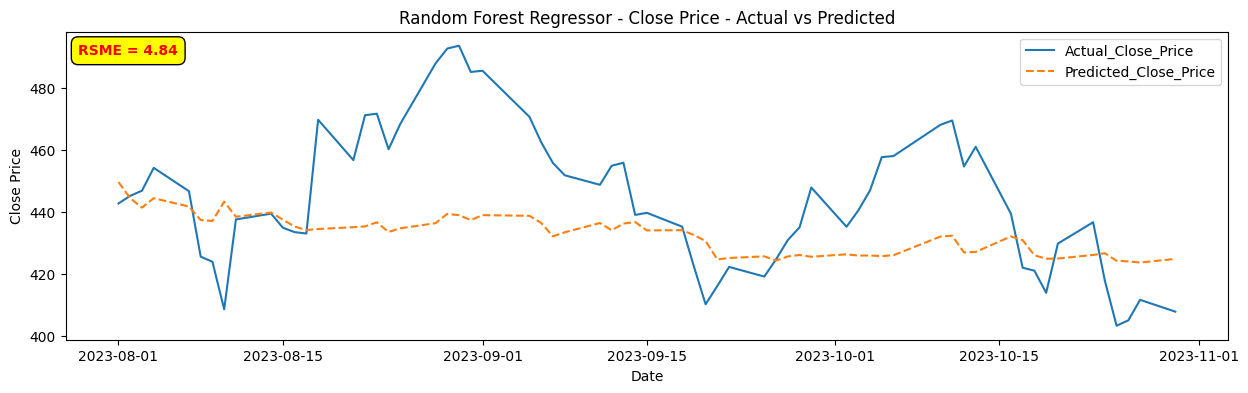

In [10]:
actual_predict_merge_df = merge_results(y_test, y_pred, NVDA_STOCK)
plt.figure(figsize=(15, 4))
plt.plot(actual_predict_merge_df['Actual'], label="Actual_Close_Price", linestyle="solid")
plt.plot(
    actual_predict_merge_df['Predicted'],
    label="Predicted_Close_Price",
    linestyle="dashed",
)
plt.title("Random Forest Regressor - Close Price - Actual vs Predicted")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.figtext(
    0.20,
    0.85,
    f"RSME = {RMSE:.2f}",
    ha="right",
    va="top",
    color="red",
    weight="bold",
    bbox=dict(facecolor="yellow", edgecolor="black", boxstyle="round,pad=0.5"),
)
plt.show()

### Trading Signals

In [11]:
trade_txn_df, trade_txn_log_df = execute_trade(actual_predict_merge_df, 10000)
trade_txn_df

,Date,Stock,Action,Portfolio,Stocks,Balance_init,Total($)
0,2023-08-01,442.690002,Buy,9739.18,22,260,9999.18
1,2023-08-02,445.149994,Sell,0.00,0,0,10053.30
2,2023-08-03,446.799988,Price-Prediction-Already-Lower,0.00,0,0,10053.30
3,2023-08-04,454.170013,Price-Prediction-Already-Lower,0.00,0,0,10053.30
4,2023-08-07,446.640015,Price-Prediction-Already-Lower,0.00,0,0,10053.30
...,...,...,...,...,...,...,...
57,2023-10-23,436.630005,Price-Prediction-Already-Lower,0.00,0,0,11594.50
58,2023-10-24,417.790009,Buy,11280.33,27,314,11594.33
59,2023-10-25,403.260010,Bought-Holding,10888.02,27,314,11202.02
60,2023-10-26,405.000000,Bought-Holding,10935.00,27,314,11249.00


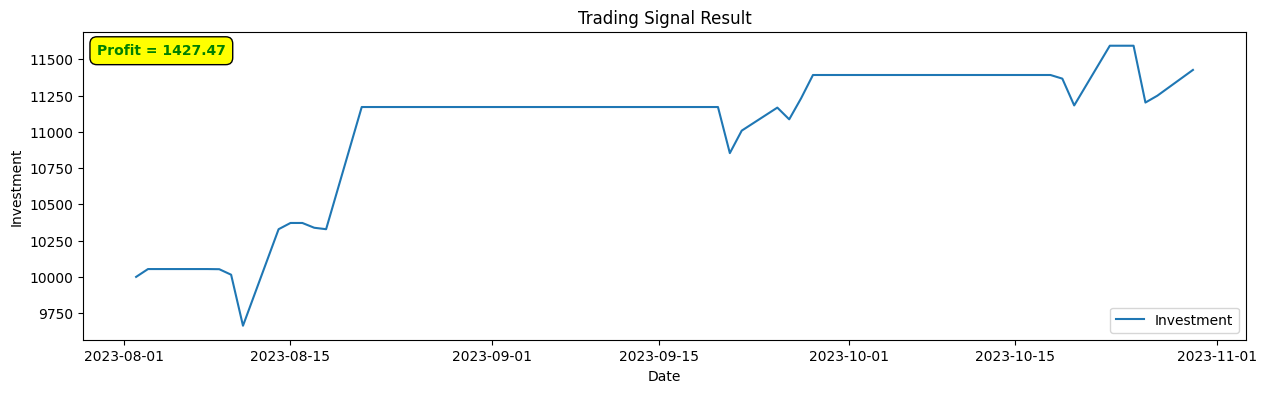

In [12]:
plt.figure(figsize=(15, 4))
plt.plot(trade_txn_log_df["Amount($)"], label="Actual_Close_Price", linestyle="solid")
plt.title("Trading Signal Result")
plt.xlabel("Date")
plt.ylabel("Investment")
plt.legend(labels = ['Investment'], loc='lower right')
plt.figtext(
    0.22,
    0.85,
    f"Profit = {trade_txn_df['Total($)'].iloc[-1]-10000:.2f}",
    ha="right",
    va="top",
    color="green",
    weight="bold",
    bbox=dict(facecolor="yellow", edgecolor="black", boxstyle="round,pad=0.5"),
)
plt.show()

## Ridge Regression

In [13]:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

alphas = [0.1, 0.5, 1.0, 5.0, 10.0]

for alpha in alphas:
    with mlflow.start_run():
        ridge = Ridge(alpha=alpha)
        ridge.fit(X_train_scaled, y_train)

        y_pred = ridge.predict(X_test_scaled)
        MSE = mean_squared_error(y_test, y_pred, squared=False)
        RMSE = math.sqrt(MSE)

        mlflow.set_tag("model", "Ridge")
        mlflow.log_metric("RMSE", RMSE)

        print(f"Ridge - RMSE: {RMSE:.2f}")

Ridge - RMSE: 3.57
Ridge - RMSE: 3.71
Ridge - RMSE: 3.76
Ridge - RMSE: 3.95
Ridge - RMSE: 4.24


### Retrive the best model

In [14]:
best_run_id = runs = client.search_runs(
    experiment_ids=EXPERIMENT_ID,
    run_view_type=ViewType.ACTIVE_ONLY,
    max_results=1,
    order_by=["metrics.RMSE ASC"],
    filter_string="tags.model = 'Ridge'",
)[0].info.run_id
print(f"Best Run ID: {best_run_id}")

loaded_model = mlflow.pyfunc.load_model(f"runs:/{best_run_id}/model")
y_pred = loaded_model.predict(X_test_scaled)

MSE = mean_squared_error(y_test, y_pred, squared=False)
RMSE = math.sqrt(MSE)

print(f"Ridge - RMSE: {RMSE}")

Best Run ID: 0179e0bf88994e53812a2772fdd97367


Ridge - RMSE: 3.5650550859818138


### Plot Actual and Predicted

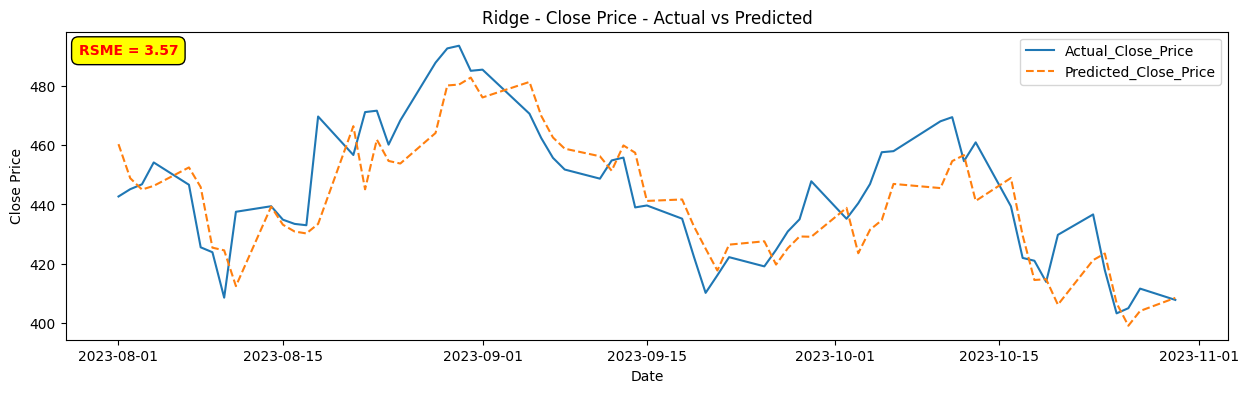

In [15]:
actual_predict_merge_df = merge_results(y_test, y_pred, NVDA_STOCK)
plt.figure(figsize=(15, 4))
plt.plot(actual_predict_merge_df['Actual'], label="Actual_Close_Price", linestyle="solid")
plt.plot(
    actual_predict_merge_df['Predicted'],
    label="Predicted_Close_Price",
    linestyle="dashed",
)
plt.title("Ridge - Close Price - Actual vs Predicted")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.figtext(
    0.20,
    0.85,
    f"RSME = {RMSE:.2f}",
    ha="right",
    va="top",
    color="red",
    weight="bold",
    bbox=dict(facecolor="yellow", edgecolor="black", boxstyle="round,pad=0.5"),
)
plt.show()

### Trading Signal

In [16]:
trade_txn_df, trade_txn_log_df = execute_trade(actual_predict_merge_df, 10000)
trade_txn_df

,Date,Stock,Action,Portfolio,Stocks,Balance_init,Total($)
0,2023-08-01,442.690002,Buy,9739.18,22,260,9999.18
1,2023-08-02,445.149994,Sell,0.00,0,0,10053.30
2,2023-08-03,446.799988,Price-Prediction-Already-Lower,0.00,0,0,10053.30
3,2023-08-04,454.170013,Price-Prediction-Already-Lower,0.00,0,0,10053.30
4,2023-08-07,446.640015,Price-Prediction-Already-Lower,0.00,0,0,10053.30
...,...,...,...,...,...,...,...
57,2023-10-23,436.630005,Price-Prediction-Already-Lower,0.00,0,0,10849.25
58,2023-10-24,417.790009,Price-Prediction-Already-Lower,0.00,0,0,10849.25
59,2023-10-25,403.260010,Price-Prediction-Already-Lower,0.00,0,0,10849.25
60,2023-10-26,405.000000,Price-Prediction-Already-Lower,0.00,0,0,10849.25


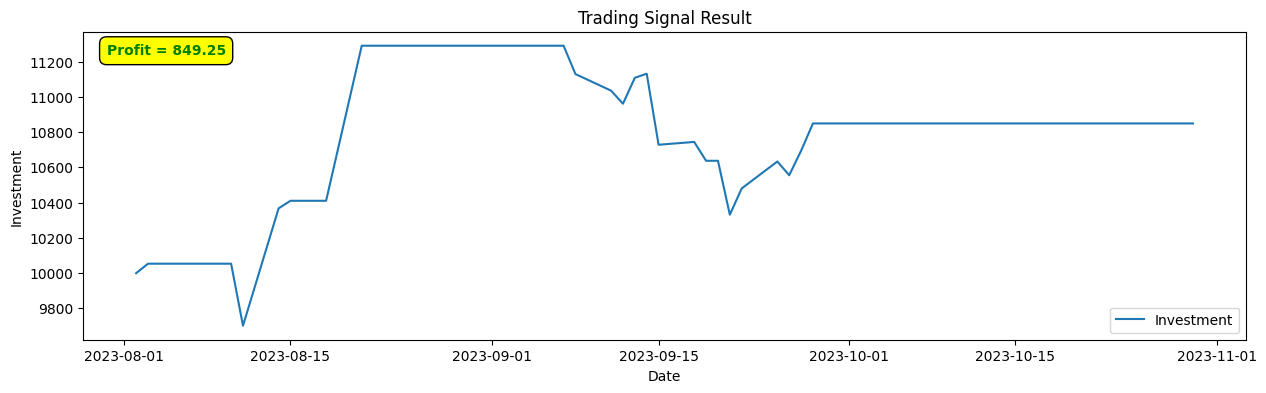

In [17]:
plt.figure(figsize=(15, 4))
plt.plot(trade_txn_log_df["Amount($)"], label="Actual_Close_Price", linestyle="solid")
plt.title("Trading Signal Result")
plt.xlabel("Date")
plt.ylabel("Investment")
plt.legend(labels = ['Investment'], loc='lower right')
plt.figtext(
    0.22,
    0.85,
    f"Profit = {trade_txn_df['Total($)'].iloc[-1]-10000:.2f}",
    ha="right",
    va="top",
    color="green",
    weight="bold",
    bbox=dict(facecolor="yellow", edgecolor="black", boxstyle="round,pad=0.5"),
)
plt.show()

## LASSO

In [18]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Set up a range of alpha values to test
alphas = [5, 0.5, 0.05, 0.005, 0.0005, 1, 0.1, 0.01, 0.001, 0.0001, 0]

for alpha in alphas:
    with mlflow.start_run():
        lr = Lasso(alpha=alpha, max_iter=10000)
        lr.fit(X_train_scaled, y_train)

        y_pred = lr.predict(X_test_scaled)
        MSE = mean_squared_error(y_test, y_pred, squared=False)

        RMSE = math.sqrt(MSE)
        mlflow.set_tag("model", "Lasso")
        mlflow.log_metric("RMSE", RMSE)

        print(f"Lasso - RMSE: {RMSE:.2f}")

Lasso - RMSE: 4.36
Lasso - RMSE: 3.47
Lasso - RMSE: 3.61
Lasso - RMSE: 3.47


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.213e+03, tolerance: 2.941e+02
  model = cd_fast.enet_coordinate_descent(


Lasso - RMSE: 3.47
Lasso - RMSE: 3.57
Lasso - RMSE: 3.58
Lasso - RMSE: 3.48


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.187e+03, tolerance: 2.941e+02
  model = cd_fast.enet_coordinate_descent(


Lasso - RMSE: 3.47


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.169e+04, tolerance: 2.941e+02
  model = cd_fast.enet_coordinate_descent(


Lasso - RMSE: 3.47


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.273e+04, tolerance: 2.941e+02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


Lasso - RMSE: 3.47


### Retrive the best model


In [19]:
best_run_id = runs = client.search_runs(
    experiment_ids=EXPERIMENT_ID,
    run_view_type=ViewType.ACTIVE_ONLY,
    max_results=1,
    order_by=["metrics.RMSE ASC"],
    filter_string="tags.model = 'Lasso'",
)[0].info.run_id
print(f"Best Run ID: {best_run_id}")

loaded_model = mlflow.pyfunc.load_model(f"runs:/{best_run_id}/model")
y_pred = loaded_model.predict(X_test_scaled)

MSE = mean_squared_error(y_test, y_pred, squared=False)
RMSE = math.sqrt(MSE)

print(f"Lasso - RMSE: {RMSE}")

Best Run ID: 9f1d696124d342e5b9a8a5f7596626e5


Lasso - RMSE: 3.4659415756258536


### Plot Actual and Predicted

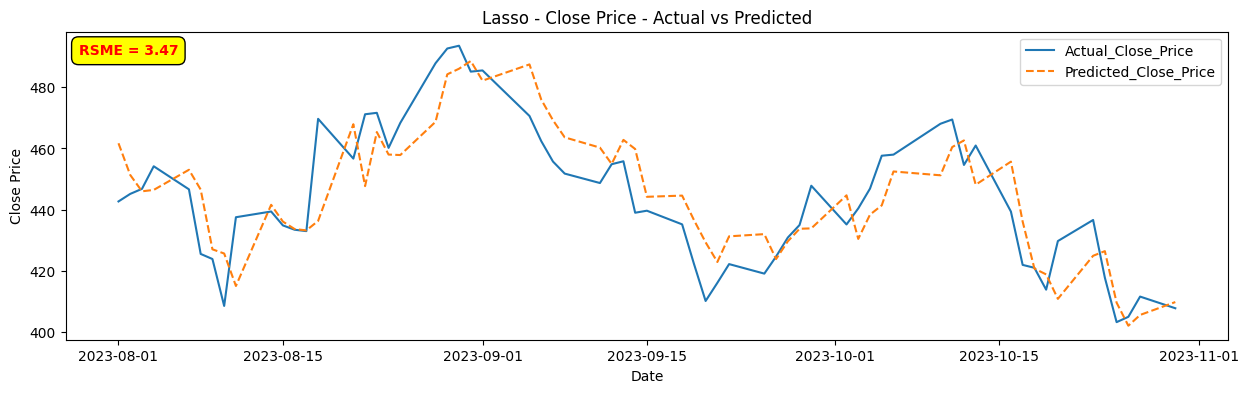

In [20]:
actual_predict_merge_df = merge_results(y_test, y_pred, NVDA_STOCK)
plt.figure(figsize=(15, 4))
plt.plot(actual_predict_merge_df['Actual'], label="Actual_Close_Price", linestyle="solid")
plt.plot(
    actual_predict_merge_df['Predicted'],
    label="Predicted_Close_Price",
    linestyle="dashed",
)
plt.title("Lasso - Close Price - Actual vs Predicted")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.figtext(
    0.20,
    0.85,
    f"RSME = {RMSE:.2f}",
    ha="right",
    va="top",
    color="red",
    weight="bold",
    bbox=dict(facecolor="yellow", edgecolor="black", boxstyle="round,pad=0.5"),
)
plt.show()

### Trading Signals

In [21]:
trade_txn_df, trade_txn_log_df = execute_trade(actual_predict_merge_df, 10000)
trade_txn_df

,Date,Stock,Action,Portfolio,Stocks,Balance_init,Total($)
0,2023-08-01,442.690002,Buy,9739.18,22,260,9999.18
1,2023-08-02,445.149994,Bought-Holding,9793.30,22,260,10053.30
2,2023-08-03,446.799988,Sell,0.00,0,0,10089.60
3,2023-08-04,454.170013,Price-Prediction-Already-Lower,0.00,0,0,10089.60
4,2023-08-07,446.640015,Price-Prediction-Already-Lower,0.00,0,0,10089.60
...,...,...,...,...,...,...,...
57,2023-10-23,436.630005,Price-Prediction-Already-Lower,0.00,0,0,10542.76
58,2023-10-24,417.790009,Price-Prediction-Already-Lower,0.00,0,0,10542.76
59,2023-10-25,403.260010,Price-Prediction-Already-Lower,0.00,0,0,10542.76
60,2023-10-26,405.000000,Buy,10530.00,26,12,10542.00


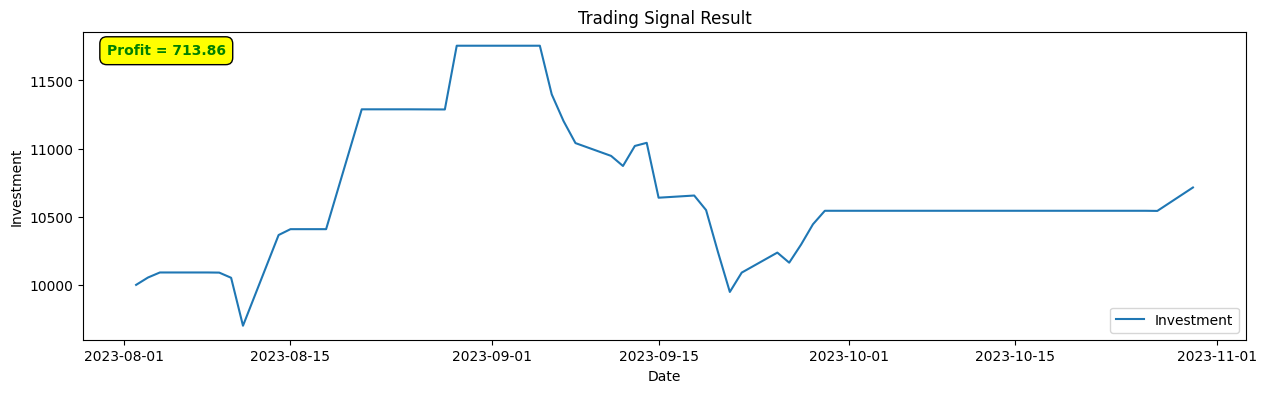

In [22]:
plt.figure(figsize=(15, 4))
plt.plot(trade_txn_log_df["Amount($)"], label="Actual_Close_Price", linestyle="solid")
plt.title("Trading Signal Result")
plt.xlabel("Date")
plt.ylabel("Investment")
plt.legend(labels = ['Investment'], loc='lower right')
plt.figtext(
    0.22,
    0.85,
    f"Profit = {trade_txn_df['Total($)'].iloc[-1]-10000:.2f}",
    ha="right",
    va="top",
    color="green",
    weight="bold",
    bbox=dict(facecolor="yellow", edgecolor="black", boxstyle="round,pad=0.5"),
)
plt.show()

## Extreme Gradient Boosting (XGBoost) Regressors


In [23]:
train = xgb.DMatrix(X_train, label=y_train)
valid = xgb.DMatrix(X_test, label=y_test)

def objective(params):
    with mlflow.start_run():
        # mlflow.log_params(params) # Check here Anku
        booster = xgb.train(
            params=params,
            dtrain=train,
            num_boost_round=1000,
            evals=[(valid, "validation")],
            early_stopping_rounds=50,
        )
        y_pred = booster.predict(valid)
        MSE = mean_squared_error(y_test, y_pred, squared=False)
        RMSE = math.sqrt(MSE)
        mlflow.set_tag("model", "XGBoost")
        mlflow.log_metric("RMSE", RMSE)

    return {"loss": RMSE, "status": STATUS_OK}

In [ ]:
search_space = {
    "max_depth": scope.int(hp.quniform("max_depth", 4, 100, 1)),
    "learning_rate": hp.loguniform("learning_rate", -3, 0),
    "reg_alpha": hp.loguniform("reg_alpha", -5, -1),
    "reg_lambda": hp.loguniform("reg_lambda", -6, -1),
    "min_child_weight": hp.loguniform("min_child_weight", -1, 3),
    "objective": "reg:linear",
    "seed": 42,
}

best_result = fmin(
    fn=objective, space=search_space, algo=tpe.suggest, max_evals=50, trials=Trials()
)

### Retrive the best model


In [25]:
best_run_id = runs = client.search_runs(
    experiment_ids=EXPERIMENT_ID,
    run_view_type=ViewType.ACTIVE_ONLY,
    max_results=1,
    order_by=["metrics.RMSE ASC"],
    filter_string="tags.model = 'XGBoost'",
)[0].info.run_id

print(f"Best Run ID: {best_run_id}")
loaded_model = mlflow.pyfunc.load_model(f"runs:/{best_run_id}/model")
y_pred = loaded_model.predict(X_test)

MSE = mean_squared_error(y_test, y_pred, squared=False)
RMSE = math.sqrt(MSE)

print(f"XGBoost - RMSE: {RMSE}")

Best Run ID: 804c9f0a5a1745288e66853dc2f8a2cb


XGBoost - RMSE: 4.2126392354161695


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [04:37:19] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


### Plot Actual and Predicted

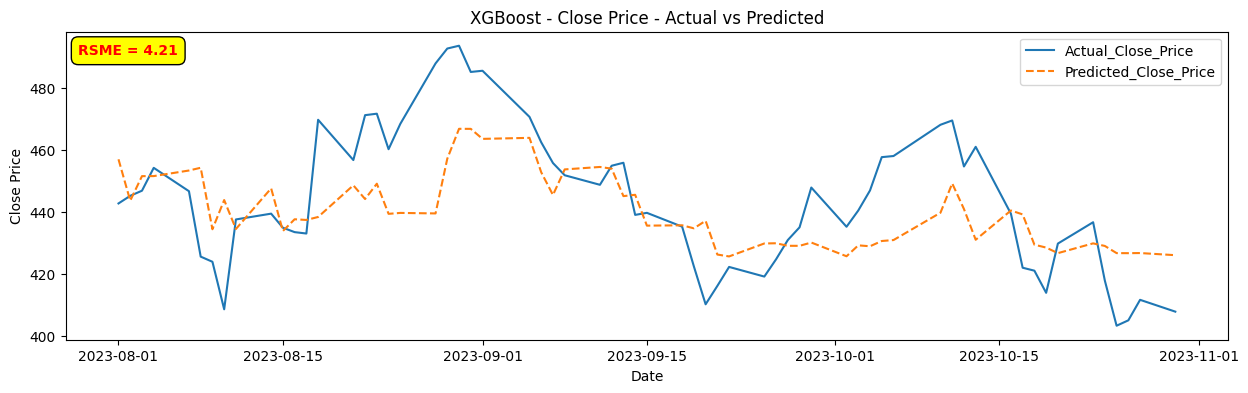

In [26]:
actual_predict_merge_df = merge_results(y_test, y_pred, NVDA_STOCK)
plt.figure(figsize=(15, 4))
plt.plot(actual_predict_merge_df['Actual'], label="Actual_Close_Price", linestyle="solid")
plt.plot(
    actual_predict_merge_df['Predicted'],
    label="Predicted_Close_Price",
    linestyle="dashed",
)
plt.title("XGBoost - Close Price - Actual vs Predicted")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.figtext(
    0.20,
    0.85,
    f"RSME = {RMSE:.2f}",
    ha="right",
    va="top",
    color="red",
    weight="bold",
    bbox=dict(facecolor="yellow", edgecolor="black", boxstyle="round,pad=0.5"),
)
plt.show()

### Trading Signal

In [27]:
trade_txn_df, trade_txn_log_df = execute_trade(actual_predict_merge_df, 10000)
trade_txn_df

,Date,Stock,Action,Portfolio,Stocks,Balance_init,Total($)
0,2023-08-01,442.690002,Buy,9739.18,22,260,9999.18
1,2023-08-02,445.149994,Bought-Holding,9793.30,22,260,10053.30
2,2023-08-03,446.799988,Bought-Holding,9829.60,22,260,10089.60
3,2023-08-04,454.170013,Sell,0.00,0,0,10251.74
4,2023-08-07,446.640015,Buy,9826.08,22,425,10251.08
...,...,...,...,...,...,...,...
57,2023-10-23,436.630005,Sell,0.00,0,0,11558.38
58,2023-10-24,417.790009,Buy,11280.33,27,278,11558.33
59,2023-10-25,403.260010,Bought-Holding,10888.02,27,278,11166.02
60,2023-10-26,405.000000,Bought-Holding,10935.00,27,278,11213.00


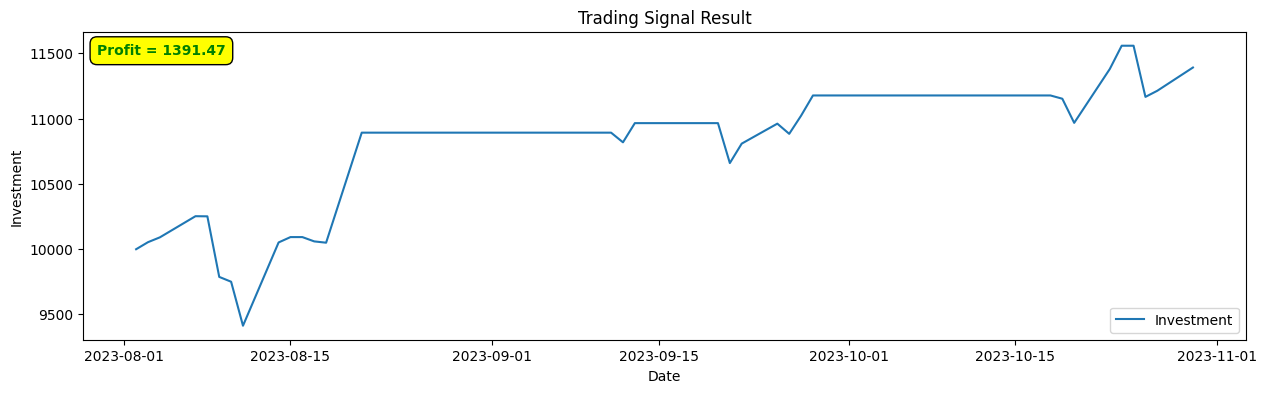

In [28]:
plt.figure(figsize=(15, 4))
plt.plot(trade_txn_log_df["Amount($)"], label="Actual_Close_Price", linestyle="solid")
plt.title("Trading Signal Result")
plt.xlabel("Date")
plt.ylabel("Investment")
plt.legend(labels = ['Investment'], loc='lower right')
plt.figtext(
    0.22,
    0.85,
    f"Profit = {trade_txn_df['Total($)'].iloc[-1]-10000:.2f}",
    ha="right",
    va="top",
    color="green",
    weight="bold",
    bbox=dict(facecolor="yellow", edgecolor="black", boxstyle="round,pad=0.5"),
)
plt.show()